In [1]:
!nvidia-smi

Sun Jun 18 13:22:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0              10W /  67W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#! pip install -q langchain transformers sentence_transformers llama-index

In [22]:
from llama_index import SimpleDirectoryReader, LangchainEmbedding, GPTListIndex, PromptHelper, GPTVectorStoreIndex
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from llama_index import LLMPredictor, ServiceContext
import torch
from langchain.llms.base import LLM
from transformers import pipeline
from llama_index import Document
from tokenize_uk import tokenize_sents as tkn

In [4]:
class customLLM(LLM):
    model_name = "google/flan-t5-large"
    pipeline = pipeline("text2text-generation", model=model_name, device=0, model_kwargs={"torch_dtype":torch.bfloat16})

    def _call(self, prompt, stop=None):
        return self.pipeline(prompt, max_length=9999)[0]["generated_text"]
    
    @property
    def _identifying_params(self):
        return {"name_of_model": self.model_name}
    @property
    def _llm_type(self):
        return "custom"


llm_predictor = LLMPredictor(llm=customLLM())

In [14]:
translator_ukr_to_en = pipeline(model = "Helsinki-NLP/opus-mt-uk-en", device=0)
translator_en_to_ukr = pipeline(model = "Helsinki-NLP/opus-mt-en-uk", device=0)

C:\Users\Ciri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [6]:
hfemb = HuggingFaceEmbeddings()
embed_model = LangchainEmbedding(hfemb)

In [7]:
! pip install PyPDF2
from PyPDF2 import PdfReader


## **Задання шляху до файлу**

In [8]:
doc = PdfReader('Task.pdf')
print(len(doc.pages))

1128


In [34]:
text = ""
text_tr = ""
for i in range(100,200):
   page = doc.pages[i]
   text_from_page = page.extract_text()
   text_tokenized = tkn(text_from_page)
   for temp in text_tokenized:
      a = translator_ukr_to_en(temp)
      text_tr = "".join(str(k) for k in a[0]['translation_text'])
      text += text_tr

print(text)

Your input_length: 493 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


100 Table End. 1.22 1 2 3 4 5 6 Wake up, hail. 30,60 45 - Reset, hail 17 20 21 21 - Bar, m 1 1 1 1 1.0.8 Maximum speed, km/h 130 130 180 Point at, km 1000 1000 950 1000 700 1.1.3.gr.6.The MIC - 3927 M.I.B.S.A. family of VHC - 3927 (I.V.A.) trained to transport personnel, load, load, and load the armory platform of various military units, and pull the trailers up to 2.5 tons.4 / 1Bronzeavtomobiles VPK - 3927 (Walk) and VPC - 39273 יהוה In the perspective of the forebears, they are equipped with military uniforms and special unitizations.On the base of the armor-auto-mobile, it's designed and modified to do various combat tasks.The modular design of cars allows even in the field, in short and time, to alter the assignment of a car by installing the modules of the required purpose: ❏ trucks, including protected ones;  own modules: communication systems, engineering and rear services; יהוה arms complexes יהוה PCC, mortar installations, communicable devices, fire support.The armory module d

In [35]:
text_list = [text]

documents = [Document(t) for t in text_list]

In [ ]:
# # set number of output tokens
# num_output = 500
# # set maximum input size
# max_input_size = 512
# # set maximum chunk overlap
# max_chunk_overlap = 15


# prompt_helper = PromptHelper(max_input_size, num_output, max_chunk_overlap)

In [36]:
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor, embed_model=embed_model)
index = GPTVectorStoreIndex.from_documents(documents, service_context=service_context)

In [37]:
import logging

logging.getLogger().setLevel(logging.CRITICAL)
     

## **Введення запитання:**

In [38]:
question_ukr = "Яка вартість нового Т-90?"

b = translator_ukr_to_en(question_ukr)
question_eng = b[0]['translation_text']
print(question_eng)

What's the value of a new T-90?


In [39]:
query_engine = index.as_query_engine()
response = query_engine.query(str(question_eng))

c = translator_en_to_ukr(response.response)
c[0]['translation_text']

'70 мільйонів миль рублів на рік'

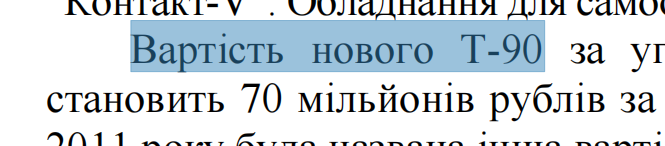